## Comparison of the Glen-and-Isaacs and the Saltenis estimators

One starts off by importing the relevant libraries and functions. The analytical values of the total indices are also imported so as to benchmark the values estimated.

In [1]:
%matplotlib inline
from Functions import A1, A2, B1, B2, B3, C1, C2
import numpy as np
import pandas as pd
import sobol_seq
import matplotlib.pyplot as plt
from pandas import ExcelWriter
plt.style.use('ggplot')

The low-discrepancy sample matrix is then imported along with a scrambling rule so as to produce 50 independent repetions one can work with to produce a stable estimate.

In [3]:
k = 6

a2 = np.array([0,0.5,3,9,99,99])
b3 = np.array([6.42,6.42,6.42,6.42,6.42,6.42])

functions = [A1, A2, B1, B2, B3, C1, C2]

AE_df = pd.read_excel('AE_df.xlsx',index_col=0) #the analytical values

def scrambler(q,s):
    return q+s

p = 14
run = 50

n = 2

df_r = pd.DataFrame(sobol_seq.i4_sobol_generate(6*k,-1+2**p))

df_index = pd.read_csv('2019.10.08_index.csv', index_col=0)

df = pd.concat([df_r.T.reindex(df_index.iloc[r]).reset_index(drop=True).T for r in range(run)])

The mean absolute errors are finally estimated across the test functions for the Glen&Isaacs estimator

In [4]:
run_samples = []

MAE_dic = {f.__name__:pd.DataFrame(columns=[r for r in range(run)]) for f in functions}
for r in range (run):
    run_samples.append(df.iloc[int(r*(len(df)/run)):int((r+1)*(len(df)/run)),:2*k].reset_index(drop=True))

    sample_Matrices = [run_samples[-1].iloc[:,m*int(len(run_samples[-1].T)/n):(m+1)*int(len(run_samples[-1].T)/n)].T.reset_index(drop=True).T
                       for m in range(n)]
    
    mixed_Matrices = []
    
    co = [1,0]
    for m in range(n):
        for j in range(k):
            mixed_Matrices.append(sample_Matrices[m].copy())
            mixed_Matrices[-1][j]=sample_Matrices[co[m]][j]
            
    gv_dic = {f.__name__:[] for f in functions}
    gv1_dic = {f.__name__:pd.DataFrame(columns=[j for j in range(k)]) for f in functions}
    gv2_dic = gv_dic.copy()
    gv3_dic = gv1_dic.copy()
    pj_dic = gv1_dic.copy()
    cd_dic = gv1_dic.copy()
    cdM_dic = gv1_dic.copy()
    ca_dic = gv1_dic.copy()
    caM_dic = gv1_dic.copy()
    ST_dic = gv1_dic.copy()
    
    for f in functions:
        gv_dic[f.__name__] = ((f(sample_Matrices[0])-f(sample_Matrices[0]).expanding(1).mean()).T/
            np.sqrt(f(sample_Matrices[0]).expanding(1).var(ddof=0))).T
        gv2_dic[f.__name__] = ((f(sample_Matrices[1])-f(sample_Matrices[1]).expanding(1).mean()).T/
            np.sqrt(f(sample_Matrices[1]).expanding(1).var(ddof=0))).T
        gv1_dic[f.__name__] = pd.DataFrame([((f(mixed_Matrices[j])-f(mixed_Matrices[j]).expanding(1).mean()).T/
            np.sqrt(f(mixed_Matrices[j]).expanding(1).var(ddof=0))).T for j in range(k)]).T
        gv3_dic[f.__name__] = pd.DataFrame([((f(mixed_Matrices[j+k])-f(mixed_Matrices[j+k]).expanding(1).mean()).T/
            np.sqrt(f(mixed_Matrices[j+k]).expanding(1).var(ddof=0))).T for j in range(k)]).T
        pj_dic[f.__name__] = pd.DataFrame([0.5*(gv_dic[f.__name__]*gv2_dic[f.__name__]+
                                       gv1_dic[f.__name__][j]*gv3_dic[f.__name__][j]).expanding(1).mean() for j in range(k)]).T
        cd_dic[f.__name__]=pd.DataFrame([0.5*(gv_dic[f.__name__]*gv3_dic[f.__name__][j]+
                                       gv2_dic[f.__name__]*gv1_dic[f.__name__][j]).expanding(1).mean() for j in range(k)]).T
        cdM_dic[f.__name__]=pd.DataFrame([0.5*(gv_dic[f.__name__]*gv1_dic[f.__name__][j]+
                                   gv2_dic[f.__name__]*gv3_dic[f.__name__][j]).expanding(1).mean() for j in range(k)]).T
        ca_dic[f.__name__]=pd.DataFrame([(cd_dic[f.__name__][j]-pj_dic[f.__name__][j]*cdM_dic[f.__name__][j])/\
        (1-(pj_dic[f.__name__][j])**2) for j in range(k)]).T
        caM_dic[f.__name__]=pd.DataFrame([(cdM_dic[f.__name__][j]-pj_dic[f.__name__][j]*cd_dic[f.__name__][j])/\
        (1-(pj_dic[f.__name__][j])**2) for j in range(k)]).T
        ST_dic[f.__name__]=pd.DataFrame([1-cdM_dic[f.__name__][j]+pj_dic[f.__name__][j]*ca_dic[f.__name__][j]/\
        (1-ca_dic[f.__name__][j]*caM_dic[f.__name__][j]) for j in range(k)]).T
        
        AE_r = np.abs(ST_dic[f.__name__] - AE_df.loc[f.__name__])
        MAE_r = AE_r.mean(axis=1)
        MAE_r.index=(MAE_r.index+1)*len(sample_Matrices)*(k+1)
        MAE_dic[f.__name__][r]=MAE_r

The trends for the two estimators are then compared across column lenght and test functions.

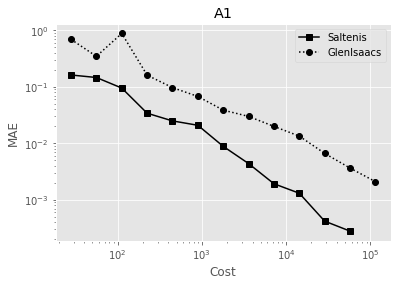

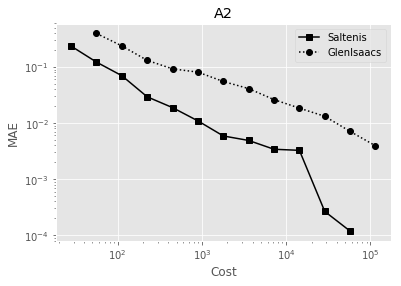

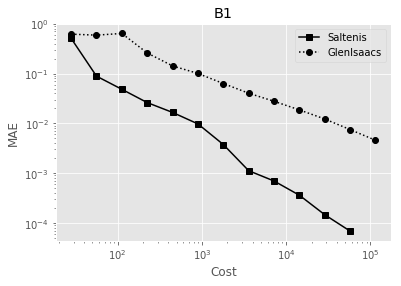

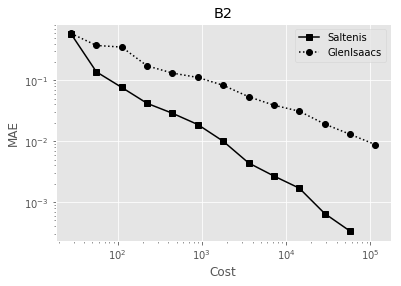

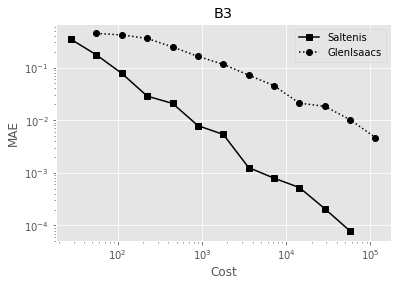

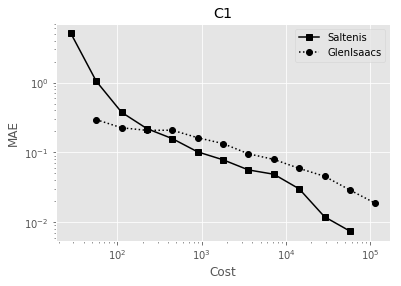

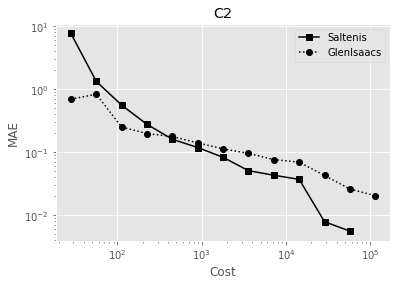

In [7]:
ls = ['-',':','-.','--',(0, (3, 5, 1, 5, 1, 5))]
mk = ['s','o','v','+','*']

for f in functions:
    Saltenis = pd.read_excel('Saltenis_asym.xlsx',sheet_name=f.__name__,index_col=0).loc[[(k+1)*2**s \
                                                                            for s in range(1,p)]].loc[(k+1)*2**2:]
    GI = MAE_dic[f.__name__].mean(axis=1).loc[[(k+1)*2**(s+1) for s in range(1,p)]].loc[(k+1)*2**2:(k+1)*2**p]
    
    dataSets = [Saltenis,GI]

    dSnames = ['Saltenis','GlenIsaacs']
    
    dS_dic = dict(zip(dSnames,dataSets))
    
    co = -1
    for dk, dv in dS_dic.items():
        co +=1
        x_vals = dv.index
        y1 = dv.values
        plt.loglog(x_vals, y1, c='k', marker = mk[co],linestyle=ls[co],label = dk)
    plt.xlabel('Cost')
    plt.ylabel('MAE')
    plt.title(f.__name__)
    plt.legend()
    plt.show()